# Install Packages and Import Libraries

First, we have to install packages and import libraries to conduct image segmentation with PyTorch.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.__version__
import PIL
PIL.__version__
from PIL import Image
from glob import glob
import os
os.getcwd()
import cv2

import torch
torch.__version__
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
torchvision.__version__
from torchvision import transforms

In [26]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

# Read CSV File

This csv file contains information as to **different classes of objects** that might be included in each image. Each class of object must have **a different color for distinction of different kinds of objects**. This table shows the corresponding colors to each class of object by the RGB values.

In [27]:
df = pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
df.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


This code shows the name of objects that can potentially appear in each image.

In [28]:
df.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

These names are packed in a list for counting the number of classes, which is necessary for the machine learning process later.

In [29]:
class_list = df.name.values.tolist()
print(class_list)
len(class_list)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


24

# Sample Images

It is important to see one or several sample original images as well as annotated images. They can be shown in the same way and in a pair. In addition, we should check the data size of these images.

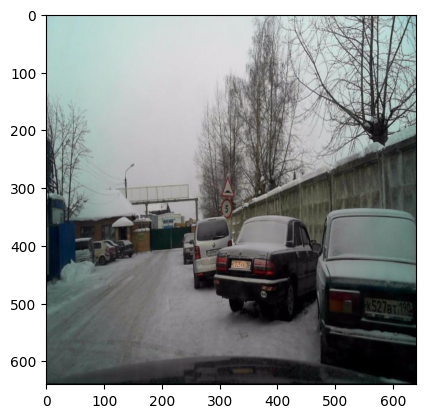

In [30]:
# original image
image = Image.open('/kaggle/input/12121212/dataset2/train/imgg/autosave01_02_2012_09_59_28_jpg.rf.b8d7c6125e9d2a03cbfea6f236d3d584.jpg')
image = np.array(image)
plt.imshow(image)

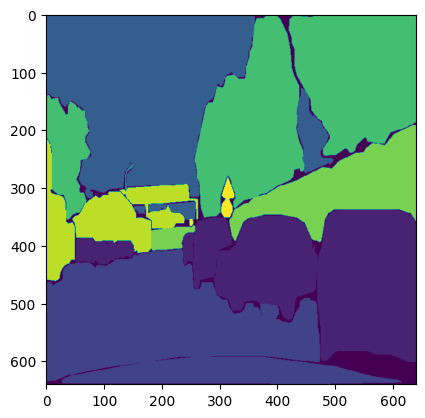

In [31]:
# label image
label = Image.open('/kaggle/input/12121212/dataset2/train/maskk/autosave01_02_2012_09_59_28_jpg.rf.b8d7c6125e9d2a03cbfea6f236d3d584_mask.png')
label = np.array(label)
plt.imshow(label)

In [32]:
image.shape, label.shape

((640, 640, 3), (640, 640))

In [33]:
image.min(), image.max()

(0, 247)

In [34]:
label.min(), label.max()

(0, 10)

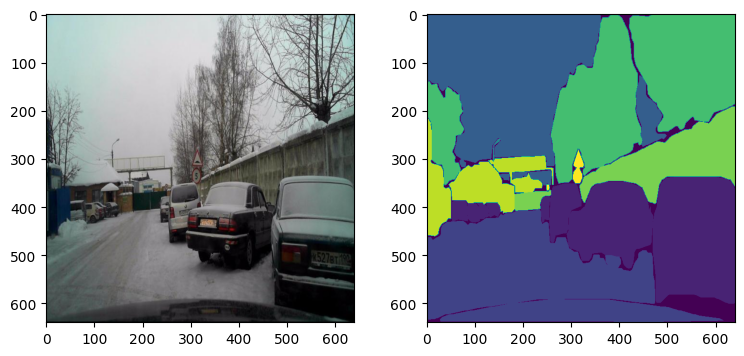

In [35]:
plt.figure(figsize = (9, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.imshow(label)

# Create Dataset and Dataloader

This is a typical sample code to create datasets to be used for training with PyTorch.

In [36]:
'''
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        self.images = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))
        self.labels = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))
        self.transform = transforms.Compose([ transforms.ToTensor() ])


    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        image = self.transform(image)

        label_path = self.labels[idx]
        label = Image.open(label_path)
        label = np.array(label)
        label = torch.tensor(label, dtype = torch.int64)
        return image, label


    def __len__(self):
        return len(self.images)
'''

"\nclass Dataset(torch.utils.data.Dataset):\n\n    def __init__(self):\n        self.images = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/*.jpg'))\n        self.labels = sorted(glob('/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/*.png'))\n        self.transform = transforms.Compose([ transforms.ToTensor() ])\n\n\n    def __getitem__(self, idx):\n        image_path = self.images[idx]\n        image = Image.open(image_path)\n        image = self.transform(image)\n\n        label_path = self.labels[idx]\n        label = Image.open(label_path)\n        label = np.array(label)\n        label = torch.tensor(label, dtype = torch.int64)\n        return image, label\n\n\n    def __len__(self):\n        return len(self.images)\n"

In [37]:
class Dataset(torch.utils.data.Dataset):
    
      def __init__(
          self,
          transform = None,
          classes = None,
          augmentation = None
          ):
        self.imgpath_list = sorted(glob('/kaggle/input/datalast22/datalast/datalast/train/imgg/*.jpg'))
        self.labelpath_list = sorted(glob('/kaggle/input/datalast22/datalast/datalast/train/maskk/*.png'))

      def __getitem__(self, i):
                
        imgpath = self.imgpath_list[i]
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize = (256, 256))
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        labelpath = self.labelpath_list[i]
        label = Image.open(labelpath)
        label = np.asarray(label)
        label = cv2.resize(label, dsize = (256, 256))
        label = torch.from_numpy(label.astype(np.float32)).clone()
        label = torch.nn.functional.one_hot(label.long(), num_classes = len(class_list))
        label = label.to(torch.float32)
        label = label.permute(2, 0, 1)

        data = {"img": img, "label": label}
        return data

      def __len__(self):
            return len(self.imgpath_list)

In [38]:
dataset = Dataset()

In [40]:
train, val, test = torch.utils.data.random_split(dataset = dataset, lengths = [230, 31, 30], generator = torch.Generator().manual_seed(42))

len(train), len(val), len(test)

(230, 31, 30)

In [41]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle = True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

# Create a Model

We create an UNet model to learn segmentation tasks. 

In [42]:
class TwoConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding = "same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet_2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock(3, 64, 64)
        self.TCB2 = TwoConvBlock(64, 128, 128)
        self.TCB3 = TwoConvBlock(128, 256, 256)
        self.TCB4 = TwoConvBlock(256, 512, 512)
        self.TCB5 = TwoConvBlock(512, 1024, 1024)
        self.TCB6 = TwoConvBlock(1024, 512, 512)
        self.TCB7 = TwoConvBlock(512, 256, 256)
        self.TCB8 = TwoConvBlock(256, 128, 128)
        self.TCB9 = TwoConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        
        self.UC1 = UpConv(1024, 512) 
        self.UC2 = UpConv(512, 256) 
        self.UC3 = UpConv(256, 128) 
        self.UC4= UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, 24, kernel_size = 1)
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim = 1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim = 1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim = 1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim = 1)
        x = self.TCB9(x)

        x = self.conv1(x)

        return x

In [43]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import segmentation_models_pytorch as smp

In [44]:
def objective(trial):
    # Гиперпараметры, которые будем оптимизировать
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = UNet_2D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

    train_loader = DataLoader(...) # Настроить DataLoader
    val_loader = DataLoader(...)   # Настроить DataLoader


In [45]:
def criterion(pred, target):
        return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)



In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet_2D().to(device)
optimizer = optim.Adam(unet.parameters(), lr = 0.0011655360518329765)

In [47]:
TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
def criterion(pred,target):
    return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)

In [48]:
history = {"train_loss": []}
n = 0
m = 0
val_loss_min = np.Inf
validation_accuracy = []
validation_loss = []

for epoch in range(15):
  train_accuracy = 0
  train_loss = 0
  val_accuracy = 0
  val_loss = 0
  correct_pixels = 0
  total_pixels = 0

# training
  unet.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data["img"].to(device), data["label"].to(device)
    optimizer.zero_grad()
    outputs = unet(inputs)
    
    # pixel accuracy
    thresholded_outputs = (outputs > 0.5).int()
    correct_pixels = (thresholded_outputs == labels).sum().item()
    total_pixels += (inputs.size(2) * inputs.size(3)) * inputs.size(0)
    train_acc = correct_pixels / total_pixels
    train_accuracy += train_acc
    
    # loss
    loss = criterion(outputs, labels)
    labels = ['Actual', 'Label', 'Predicted']

    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    history["train_loss"].append(loss.item())
    n += 1
    if i % ((len(train) // batch_size) // 10) == (len(train) // batch_size) // 10 - 1:
      print(f"epoch:{epoch + 1}  index:{i + 1}  train_accuracy:{train_accuracy / n:.5f}")
      print(f"epoch:{epoch + 1}  index:{i + 1}  train_loss:{train_loss / n:.5f}")
      n = 0
      train_accuracy = 0
      train_loss = 0

# validation
  unet.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      inputs, labels = data["img"].to(device), data["label"].to(device)
      outputs = unet(inputs)
       
      # pixel accuracy
      thresholded_outputs = (outputs > 0.5).int()
      correct_pixels = (thresholded_outputs == labels).sum().item()
      total_pixels += (inputs.size(2) * inputs.size(3)) * inputs.size(0)
      val_acc = correct_pixels / total_pixels
      val_accuracy += val_acc  
       
      # loss
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      m += 1
      if i % (len(val) // batch_size) == len(val) // batch_size - 1:
        print(f"epoch:{epoch + 1}  index:{i + 1}  validation_accuracy:{val_accuracy / m:.5f}")
        print(f"epoch:{epoch + 1}  index:{i + 1}  validation_loss:{val_loss / m:.5f}")
        validation_accuracy.append(val_accuracy)
        validation_loss.append(val_loss)
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            torch.save(unet.state_dict(), 'semantic_segmentation.pt')
            print('Detected network improvement, saving current model')
        
        m = 0
        val_accuracy = 0
        val_loss = 0
        
print("finish training")

epoch:1  index:5  train_accuracy:10.13260
epoch:1  index:5  train_loss:0.53227
epoch:1  index:10  train_accuracy:2.99903
epoch:1  index:10  train_loss:0.47831
epoch:1  index:15  train_accuracy:1.80629
epoch:1  index:15  train_loss:0.44371
epoch:1  index:20  train_accuracy:1.30492
epoch:1  index:20  train_loss:0.41429
epoch:1  index:25  train_accuracy:1.01920
epoch:1  index:25  train_loss:0.38852
epoch:1  index:30  train_accuracy:0.83890
epoch:1  index:30  train_loss:0.36724
epoch:1  index:35  train_accuracy:0.70858
epoch:1  index:35  train_loss:0.35297
epoch:1  index:40  train_accuracy:0.61109
epoch:1  index:40  train_loss:0.33867
epoch:1  index:45  train_accuracy:0.54593
epoch:1  index:45  train_loss:0.31371
epoch:1  index:50  train_accuracy:0.49081
epoch:1  index:50  train_loss:0.29843
epoch:1  index:55  train_accuracy:0.44172
epoch:1  index:55  train_loss:0.29161
epoch:1  index:7  validation_accuracy:0.38304
epoch:1  index:7  validation_loss:0.29007
Detected network improvement, sav

In [49]:
!pip install optuna
import optuna
import optuna.visualization as vis
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# Не забудьте определить ваш датасет и наш train и val датасеты
# Например:
# train = YourTrainDataset()
# val = YourValDataset()

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [2, 4, 8, 16])
    n_filters = 4

    # Setup data loaders
    train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with suggested number of filters
    model = UNet_2D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Initialize metrics
    num_epochs = 10
    val_loss_min = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for data in train_loader:
            inputs, labels = data["img"].to(device), data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_accuracy = 0
        val_loss = 0
        with torch.no_grad():
            m = 0
            for data in val_loader:
                inputs, labels = data["img"].to(device), data["label"].to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                m += 1
                
                thresholded_outputs = (outputs > 0.5).int()
                val_accuracy += (thresholded_outputs == labels).sum().item() / (inputs.size(2) * inputs.size(3) * inputs.size(0))
                
        val_loss /= m
        val_accuracy /= m
        
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            torch.save(model.state_dict(), 'semantic_segmentation.pt')
    
    return val_loss_min

# Создание исследования и оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print('Best hyperparameters:', study.best_trial.params)

# Визуализации
# 1. График важности гиперпараметров
fig = vis.plot_param_importances(study)
fig.show()

# 2. График истории оптимизации
fig = vis.plot_optimization_history(study)
fig.show()

# 3. Параллельные координаты
fig = vis.plot_parallel_coordinate(study)
fig.show()

# 4. Граф зависимостей (Contour plot)
fig = vis.plot_contour(study)
fig.show()

# 5. Размещение трейлов и их значений на двумерной плоскости
fig = vis.plot_slice(study)
fig.show()

# 6. График важности гиперпараметров с точки зрения гиперплоскости
fig = vis.plot_edf(study)
fig.show()

[I 2024-05-20 14:13:17,774] A new study created in memory with name: no-name-6878b8b4-ac0b-4bd7-afa8-ba8b1e23252b
/tmp/ipykernel_34/3249062242.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-05-20 14:15:41,736] Trial 0 finished with value: 0.8385149985551834 and parameters: {'lr': 0.00037902872764471163, 'batch_size': 4}. Best is trial 0 with value: 0.8385149985551834.
[I 2024-05-20 14:17:55,100] Trial 1 finished with value: 1.8320983052253723 and parameters: {'lr': 2.320269083193327e-05, 'batch_size': 16}. Best is trial 0 with value: 0.8385149985551834.
[I 2024-05-20 14:20:09,269] Trial 2 finished with value: 0.9463498592376709 and parameters: {'lr': 0.001081573682398925, 'batch_size': 16}. Best is trial 0 with value: 0.8385149985551834.
[I 2024-05-20 14:22:32,158] T

Best hyperparameters: {'lr': 0.0002797381877563456, 'batch_size': 2}


# Training and Validation Loss

We visualize the transition of the accuracy and loss during the training.

Text(0, 0.5, 'loss')

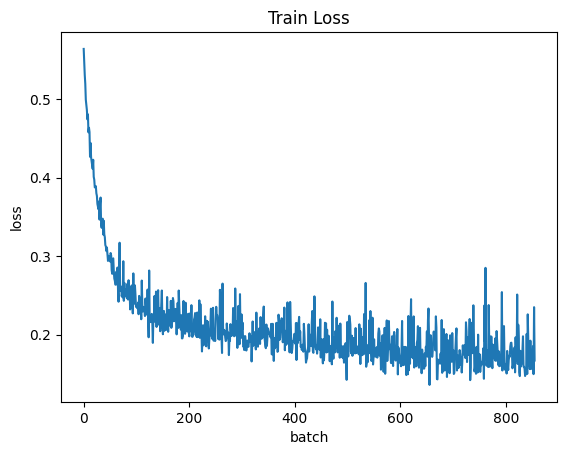

In [50]:
plt.title("Train Loss")
plt.plot(history["train_loss"])
plt.xlabel('batch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

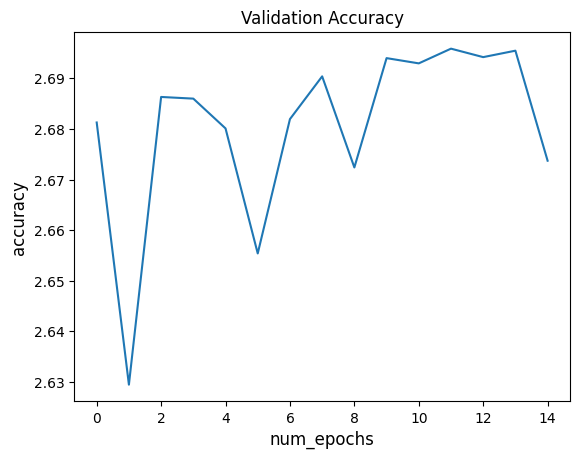

In [51]:
plt.title("Validation Accuracy")
plt.plot(validation_accuracy)
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)

Text(0, 0.5, 'loss')

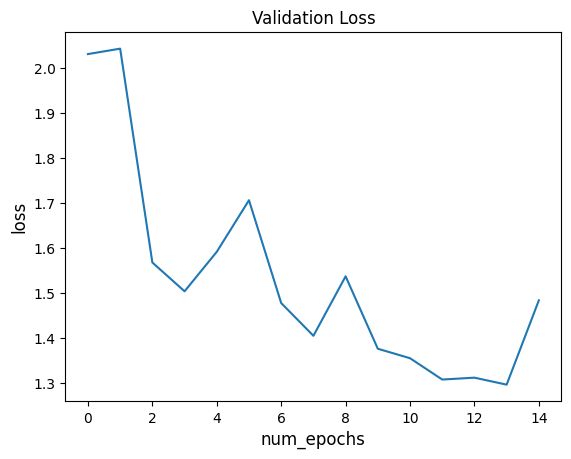

In [52]:
plt.title("Validation Loss")
plt.plot(validation_loss)
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)

# Load the Best Model

In [53]:
# import the trained network with the best loss of validation
unet.load_state_dict(torch.load('semantic_segmentation.pt'))

<All keys matched successfully>

# Prediction and Comparison with the Truth

We can compare the original images, annotated images, and predicted images to evaluate the performance by the trained segmentation model.

In [54]:
model = UNet_2D()
model.load_state_dict(torch.load("semantic_segmentation.pt"))
model.eval()
with torch.no_grad():
  data = next(iter(test_loader))
  inputs, labels = data["img"], data["label"]
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  print("Loss: ", loss.item())

  thresholded_outputs = (outputs > 0.5).int()
  intersection = torch.logical_and(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
  union = torch.logical_or(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
  iou_score = (intersection / union).mean().item()
  print("Intersection over Union:", iou_score)
  
  dice_score = ((2 * intersection) / (thresholded_outputs.sum(dim=[1, 2, 3]) + labels.sum(dim=[1, 2, 3]))).mean().item()
  print("Dice coefficient:", dice_score)


sigmoid = nn.Sigmoid()
outputs = sigmoid(outputs)
pred = torch.argmax(outputs, axis = 1)
pred = torch.nn.functional.one_hot(pred.long(), num_classes = len(class_list)).to(torch.float32)

Loss:  0.3743244409561157
Intersection over Union: 0.25218838453292847
Dice coefficient: 0.4023427367210388


(-0.5, 255.5, 255.5, -0.5)

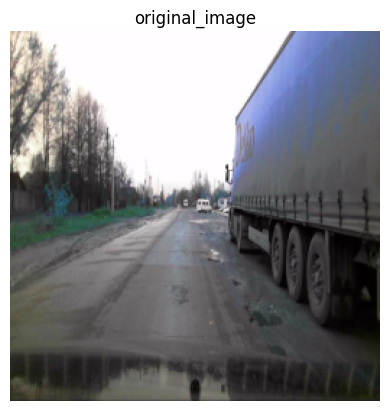

In [55]:
plt.figure()
plt.imshow(data["img"][1, :, :, :].permute(1, 2, 0))

plt.title("original_image")
plt.axis("off")

/tmp/ipykernel_34/666325080.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



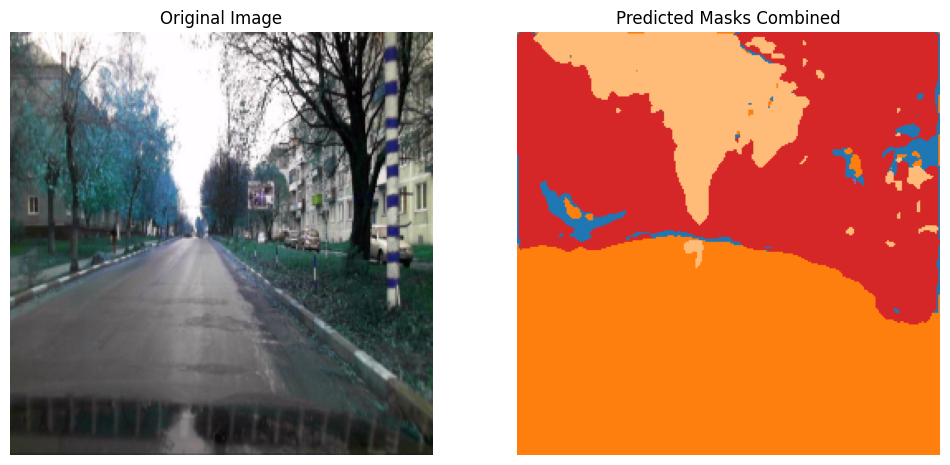

In [56]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from matplotlib.colors import ListedColormap

# Подготовка модели к работе
model = UNet_2D()
model.load_state_dict(torch.load("semantic_segmentation.pt"))
model.eval()

# Сгенерировать цвета для каждого класса
num_classes = len(class_list)
colors = plt.cm.get_cmap('tab20', num_classes)  # Получение цветовой карты с num_classes цветами

# Обработка тестовых данных
with torch.no_grad():
    data = next(iter(test_loader))
    inputs, labels = data["img"], data["label"]
    outputs = model(inputs)
    
    sigmoid = nn.Sigmoid()
    outputs = sigmoid(outputs)
    
    # Получение предсказаний для каждого класса
    pred = torch.argmax(outputs, axis=1)
    
    # Создаем цветное изображение масок
    pred_color = colors(pred[2].cpu().numpy())  # Преобразуем значения в цвета с помощью выбранной цветовой карты
    pred_color_image = pred_color[..., :3]  # Удалить альфа-канал
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(to_pil_image(inputs[2]))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_color_image)  # Отображение цветного изображения предсказаний
    plt.title('Predicted Masks Combined')
    plt.axis('off')

    plt.show()

/tmp/ipykernel_34/3045478629.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



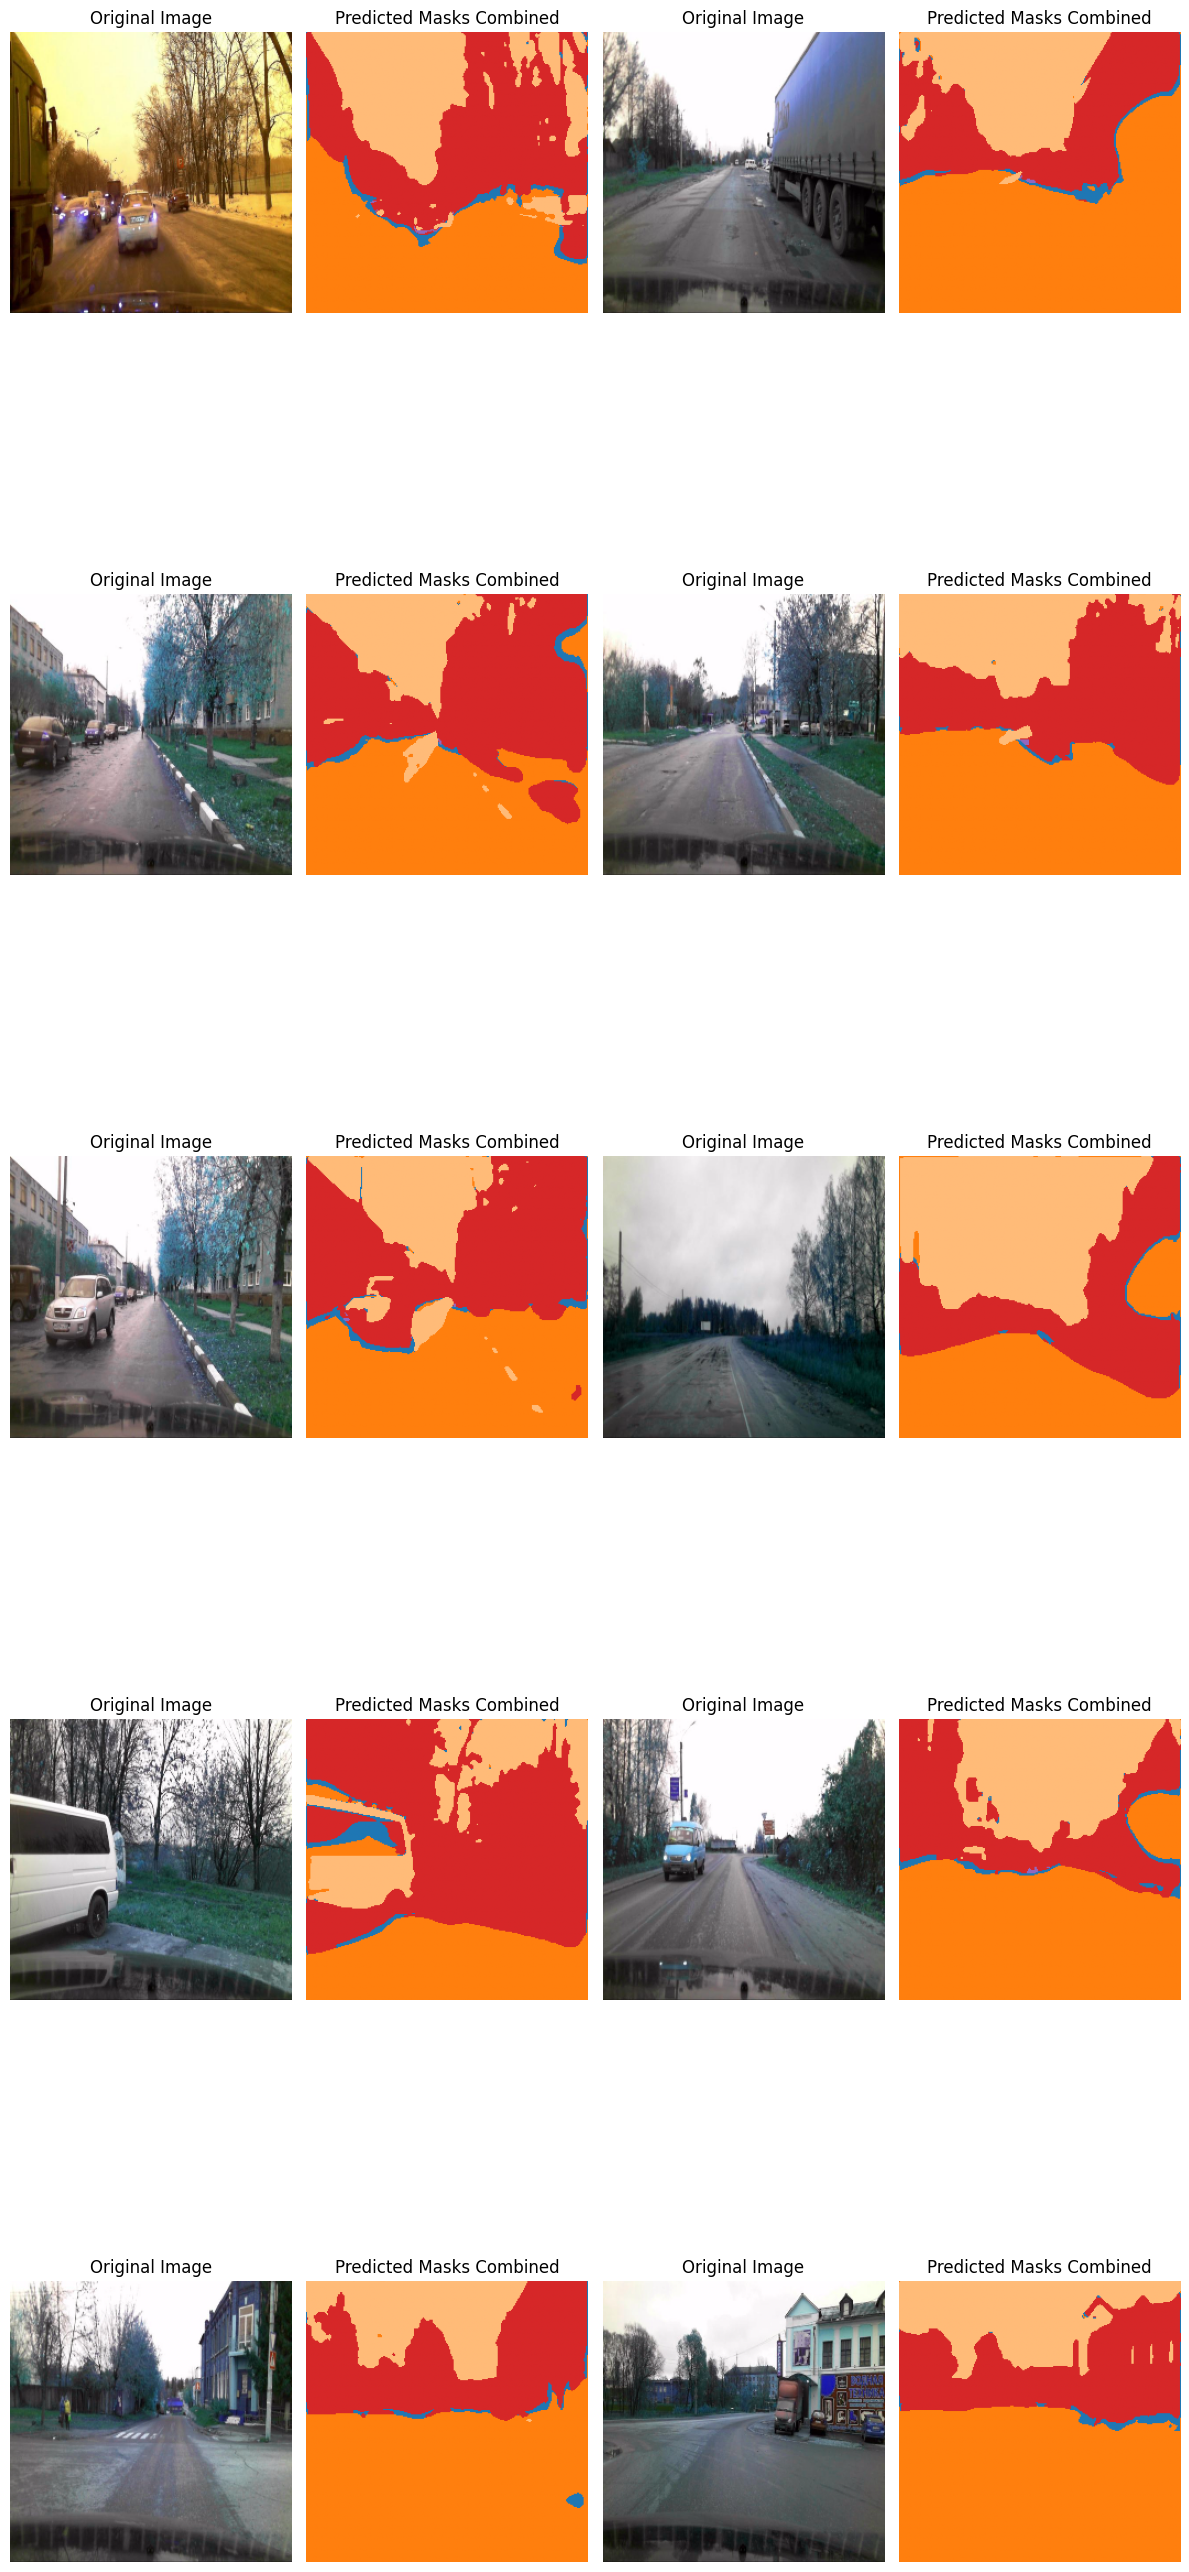

In [57]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from matplotlib.colors import ListedColormap

# Подготовка модели к работе
model = UNet_2D()
model.load_state_dict(torch.load("semantic_segmentation.pt"))
model.eval()

# Сгенерировать цвета для каждого класса
num_classes = len(class_list)
colors = plt.cm.get_cmap('tab20', num_classes)  # Получение цветовой карты с num_classes цветами

num_batches = 5  # Установка числа батчей для отображения
images_per_batch =2  # Количество изображений для отображения в каждом батче

fig, axes = plt.subplots(num_batches, images_per_batch * 2, figsize=(12, num_batches * 6))

for batch_idx, data in enumerate(test_loader):
    if batch_idx >= num_batches:
        break
    inputs, labels = data["img"], data["label"]
    outputs = model(inputs)
    
    sigmoid = nn.Sigmoid()
    outputs = sigmoid(outputs)
    
    # Получение предсказаний для каждого класса
    pred = torch.argmax(outputs, axis=1)

    for img_idx in range(images_per_batch):
        # Original image
        axes[batch_idx, img_idx * 2].imshow(to_pil_image(inputs[img_idx]))
        axes[batch_idx, img_idx * 2].set_title("Original Image")
        axes[batch_idx, img_idx * 2].axis('off')

        # Predicted mask
        pred_color = colors(pred[img_idx].cpu().numpy())
        pred_color_image = pred_color[..., :3]  # Удалить альфа-канал
        axes[batch_idx, img_idx * 2 + 1].imshow(pred_color_image)
        axes[batch_idx, img_idx * 2 + 1].set_title('Predicted Masks Combined')
        axes[batch_idx, img_idx * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

IndexError: index 7 is out of bounds for axis 0 with size 2

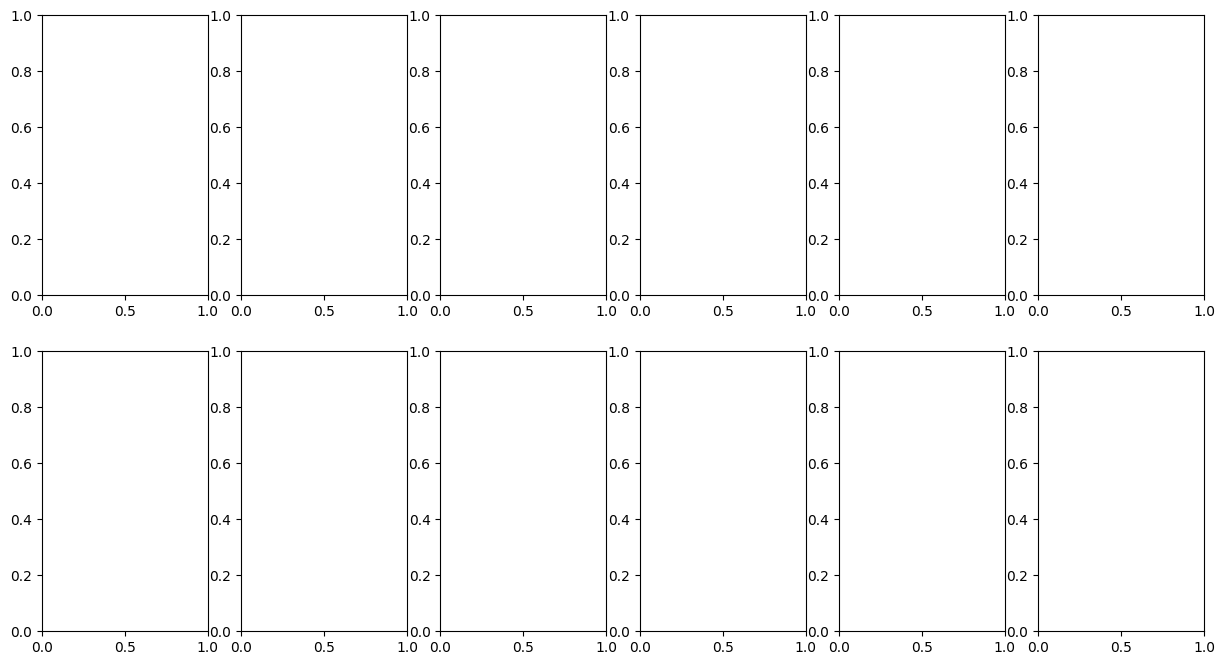

In [58]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for j, cl in enumerate(classes[6:12]):
    if i == 0 and j < 6:
        ax[i, j].imshow(pred[0, :, :, j])
        ax[i, j].set_title(f"pred_{cl}")
        ax[i, j].axis("off")
    elif j < 6:
        ax[i, j].imshow(data["label"][0, j, :, :])    
        ax[i, j].set_title(f"label_{cl}")
        ax[i, j].axis("off")

In [ ]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[12:18]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

In [ ]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[18:]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[0, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][0, j, :, :])    
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")